# **Update 3**

In [5]:
! pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 3.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset (make sure to adjust the file path)
df = pd.read_csv("car_insurance_claim.csv")

# Drop sensitive features that were removed from the model, as defined earlier
df_cleaned = df.drop(columns=['INCOME', 'HOME_VAL', 'YOJ', 'PARENT1', 'KIDSDRIV', 'HOMEKIDS',
                              'EDUCATION', 'OCCUPATION', 'MSTATUS', 'CAR_TYPE'])

# Convert categorical features to dummy variables
df_dummies = pd.get_dummies(df_cleaned, drop_first=True)

# Split data into features (X) and target (y)
X = df_dummies.drop(columns=['CLAIM_FLAG'])  # Assuming 'CLAIM_FLAG' is the target
y = df_dummies['CLAIM_FLAG']

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:
from sklearn.ensemble import RandomForestClassifier

# Train RandomForestClassifier
rf_cls = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cls.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = rf_cls.predict(X_test_scaled)

**Demographic Parity:**
This metric checks if the acceptance rate (predictions of 1 or approved) is similar across groups (e.g., gender).

**Equalized Odds:**
This metric checks if the True Positive Rate (TPR) and False Positive Rate (FPR) are the same across groups.

In [7]:
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference
import matplotlib.pyplot as plt

# Assuming 'GENDER' is the sensitive feature
sensitive_feature = df['GENDER']

# Align the sensitive feature with the test set predictions
sensitive_feature_test = sensitive_feature.iloc[X_test.index]

# Create a MetricFrame to calculate overall accuracy and fairness metrics
# Pass y_true and y_pred as separate keyword arguments
metric_frame = MetricFrame(metrics={'accuracy': (lambda y_true, y_pred: (y_true == y_pred).mean())},
                           y_true=y_test,
                           y_pred=y_pred,
                           sensitive_features=sensitive_feature_test)

# Compute Demographic Parity and Equalized Odds
dp_diff = demographic_parity_difference(y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature_test)
eo_diff = equalized_odds_difference(y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature_test)

# Print results
print("Demographic Parity Difference:", dp_diff)
print("Equalized Odds Difference:", eo_diff)

# Show the overall accuracy
print("Overall Model Accuracy:", metric_frame.overall['accuracy'])

Demographic Parity Difference: 0.001746285947935123
Equalized Odds Difference: 0.004638392024098312
Overall Model Accuracy: 0.7467248908296943


In [8]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

# Initialize the ExponentiatedGradient method with DemographicParity constraint
mitigator = ExponentiatedGradient(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    constraints=DemographicParity()
)

# Fit the mitigator to the training data
mitigator.fit(X_train_scaled, y_train, sensitive_features=sensitive_feature.iloc[X_train.index])

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x7dc86771f9d0>,
                      estimator=RandomForestClassifier(random_state=42),
                      nu=np.float64(6.067224851353035e-05))

In [9]:
# Get predictions from the mitigated model
y_pred_mitigated = mitigator.predict(X_test_scaled) # Remove sensitive_features argument

# Calculate fairness metrics after mitigation
dp_diff_mitigated = demographic_parity_difference(y_true=y_test, y_pred=y_pred_mitigated, sensitive_features=sensitive_feature_test)
eo_diff_mitigated = equalized_odds_difference(y_true=y_test, y_pred=y_pred_mitigated, sensitive_features=sensitive_feature_test)

In [10]:
# Print results for mitigated model
print("Post-Mitigation Demographic Parity Difference:", dp_diff_mitigated)
print("Post-Mitigation Equalized Odds Difference:", eo_diff_mitigated)

Post-Mitigation Demographic Parity Difference: 0.004733428740175367
Post-Mitigation Equalized Odds Difference: 0.03496121344600538


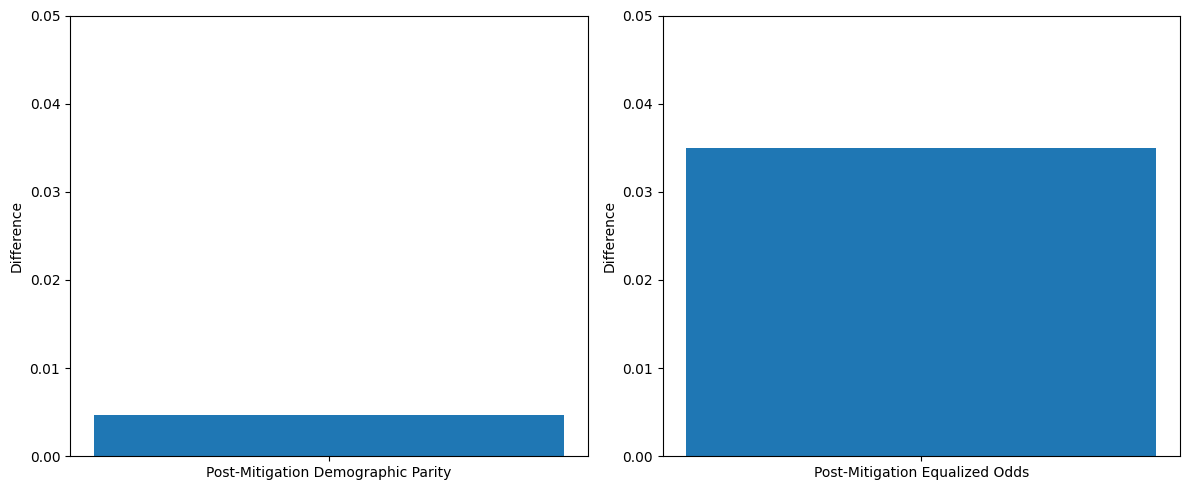

In [11]:
# Visualize the fairness metrics after mitigation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Demographic Parity Difference after mitigation
axes[0].bar(['Post-Mitigation Demographic Parity'], [dp_diff_mitigated])
axes[0].set_ylabel('Difference')
axes[0].set_ylim([0, 0.05])

# Plot Equalized Odds Difference after mitigation
axes[1].bar(['Post-Mitigation Equalized Odds'], [eo_diff_mitigated])
axes[1].set_ylabel('Difference')
axes[1].set_ylim([0, 0.05])

plt.tight_layout()
plt.show()

Accuracy Before Mitigation: 0.7467
Accuracy After Mitigation: 0.7443


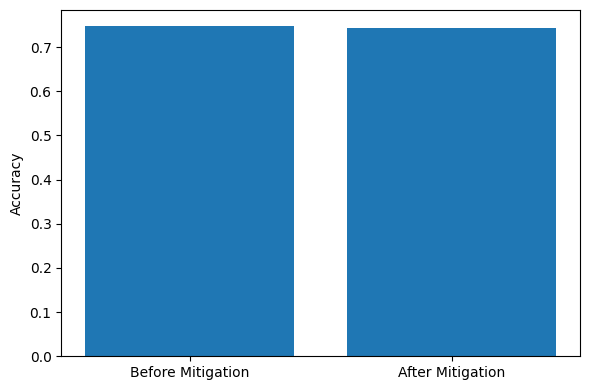

In [12]:
# Comparison before and after mitigation
# Compare overall accuracy before and after mitigation
accuracy_before = metric_frame.overall['accuracy']
accuracy_after = (y_test == y_pred_mitigated).mean()

print(f"Accuracy Before Mitigation: {accuracy_before:.4f}")
print(f"Accuracy After Mitigation: {accuracy_after:.4f}")

# Bar plot to compare accuracies
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(['Before Mitigation', 'After Mitigation'], [accuracy_before, accuracy_after])
ax.set_ylabel('Accuracy')
plt.tight_layout()
plt.show()